In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # Why the fuck this does not work with more cores?????!!!
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
from math import pi
import time
plt.rcParams.update({
    "text.usetex": True
})
plt.rcParams['figure.dpi'] = 200
def mgrid(plt):
        plt.grid(linestyle='-', which='major', linewidth=0.5 , color='grey', alpha = 0.2)
        plt.grid(linestyle=':', which='minor', linewidth=0.5 , color='grey', alpha = 0.2)

In [2]:
# If you need to work with seperate instances of CLASS

class_path = '/Users/sg58477/work/class_public/' # Path to your CLASS directory
# class_path = '/afs/crc.nd.edu/user/s/sghosh5/class_public' # Path to your CLASS directory
# class_path = '/afs/crc.nd.edu/user/s/sghosh5/scalar_cmb/AxiCLASS-32fd3df633be78c8f1c036de25b935d618ae1a59'
classy_path = ''
for elem in os.listdir(os.path.join(
        class_path, "python", "build")):
    if elem.find("lib.") != -1:
        classy_path = os.path.join(
            class_path, "python", "build", elem)
    if len(classy_path)==1:
        classy_path = classy_path[0]
    else:
        stringcheck = "%i.%i"%(sys.version_info.major,sys.version_info.minor)
        for path in classy_path:
            if stringcheck in path:
                classy_path = path
                break

# Inserting the previously found path into the list of folders to
# search for python modules.
sys.path.insert(1, classy_path)
try:
    from classy import Class
    from classy import CosmoComputationError
except ImportError:
    print('Error: Could not import Classy.')

    
M = Class()
sys.path.remove(classy_path)
del Class
del sys.modules['classy']

In [3]:
common_settings = {
                   'output': 'tCl,pCl,lCl,mPk',
                   'h':0.67556,
                   'omega_b':0.02238280,   
                   'omega_cdm':0.1201075,  
                   'A_s':2.215e-9,
                   'n_s':0.9619,
                   'tau_reio':0.05430842,
                   'YHe':'BBN',
                   'l_max_scalars':6000,
                   'k_output_values': '1, 0.1, 0.01, 0.001',
#                    'z_max_pk':100,
                   'P_k_max_1/Mpc':200.0,
                    'gauge':'sync',
                    'lensing':'yes'
                    # ,'N_ur' : 0,
                    # 'N_ncdm' : 1,
                    # 'm_ncdm' : 0.02,
                    # 'deg_ncdm' : 3
}

In [4]:
klist = np.logspace(-4,np.log10(common_settings['P_k_max_1/Mpc']),1000)

In [5]:
def cl_pk(Nur = 0, m_ncdm = 0.02, log10_G_eff = None, N_ncdm = 1, deg_ncdm = 3, Omega0_m = 0.3136284):
    M.empty()
    M.set(common_settings) 
    M.set({'N_ur' : Nur, 'N_ncdm' : N_ncdm, 'deg_ncdm':deg_ncdm, 'm_ncdm':m_ncdm})
    M.compute()
    om0_cdm_adj = Omega0_m*M.h()**2 - M.omega_b() - M.Omega_nu*M.h()**2
    M.empty()
    M.set(common_settings)
    M.set({'omega_cdm':om0_cdm_adj})
    M.set({'N_ur' : Nur, 'N_ncdm' : N_ncdm, 'deg_ncdm':deg_ncdm, 'm_ncdm':m_ncdm})
    # M.set({"ncdm_nuself_fluid_trigger_tau_c_over_tau_h":1.0e-8})
    # M.set({"ncdm_nuself_trigger_tau_c_over_tau_h":1.0e3})
    # M.set({'tol_perturbations_integration':5e-5})
    if log10_G_eff != None:
        M.set({'log10_G_eff' : log10_G_eff,'nuself_type' : 'massive'})
    M.compute()
    nucl = M.lensed_cl()
    nucl_raw = M.raw_cl()
    pnu = []
    for k in klist:
        pnu.append(M.pk(k,0))
    pnu = np.array(pnu)
    print(M.Omega0_m())
    return [nucl,nucl_raw,pnu]
    
    
        
    
    
    


In [6]:
fac = np.sqrt(1) # To benchmark with Vivian's code
# mlist = [0.06/3]
mlist = [0.06/3,0.23/3]
lgefflist  = [None,-4.0+np.log10(fac),-2.0+np.log10(fac)]
# lgefflist  = [None,-4.0+np.log10(fac)]
cll = ['k','deepskyblue', 'r']
lsl = ['-','--']

In [7]:
cl = {}
pk = {}
cl_raw = {}
for lin,lgeff in enumerate(lgefflist):
    for min,m in enumerate(mlist):
        clpk = cl_pk(m_ncdm = m, log10_G_eff = lgeff);
        cl[lin,min] = clpk[0]
        cl_raw[lin,min] = clpk[1]
        pk[lin,min] = clpk[2]
        

0.31362710980440306
0.3136280630882033
0.31362710980440306
0.3136280630882033
0.31362710980440306
0.3136280630882033


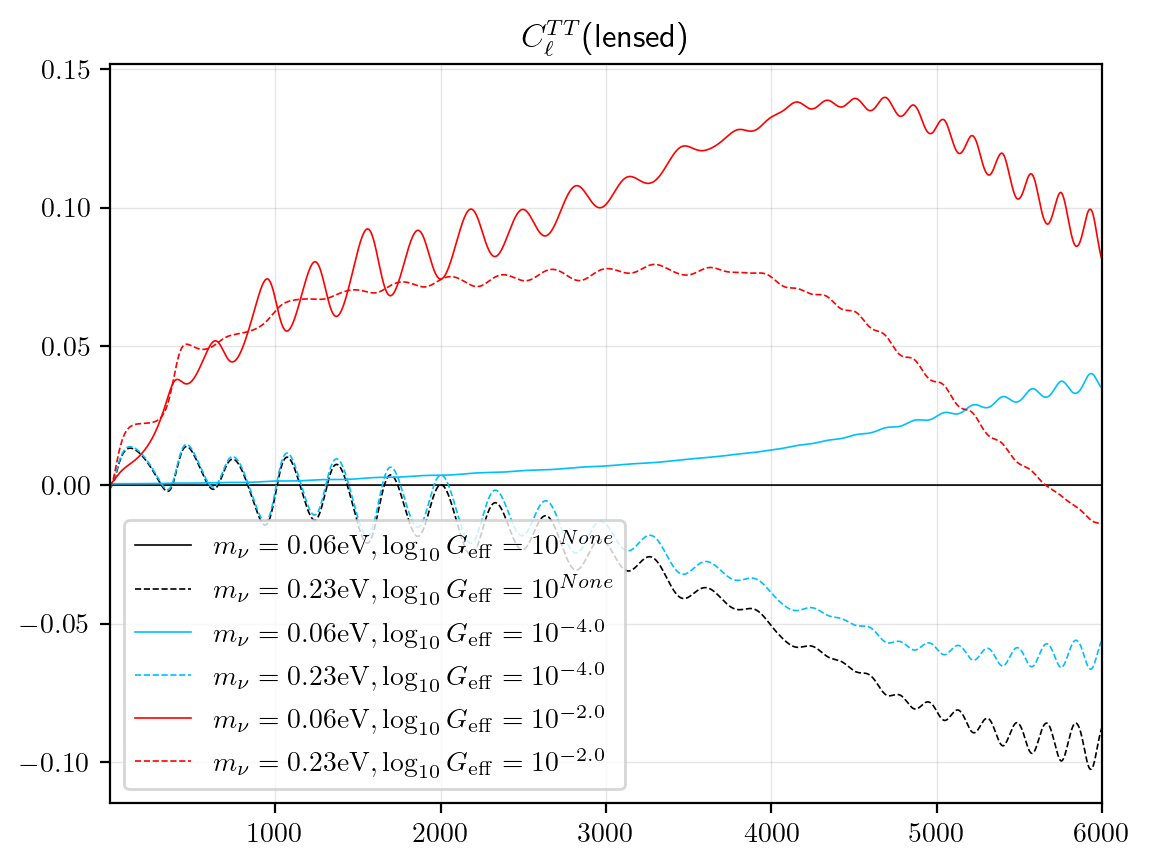

In [8]:
for lin,lgeff in enumerate(lgefflist):
    for mind,m in enumerate(mlist):
        plt.plot(cl[lin,mind]['ell'][2:],cl[lin,mind]['tt'][2:]/cl[0,0]['tt'][2:] - 1, label = fr'$m_\nu = {round(3*m,2)}{{\rm eV}},\log_{{10}} G_{{\rm eff}} = 10^{{{lgeff}}}$', c = cll[lin],ls = lsl[mind], lw = 0.6)
plt.xlim([2,6000]) 
# plt.ylim([-0.08,0.12])
mgrid(plt)
# plt.yticks([-0.06,-0.02,0.02,0.06,0.1])
plt.legend()
plt.title('$C_\ell^{TT}$(lensed)')
plt.savefig('cl_TT_r.pdf')


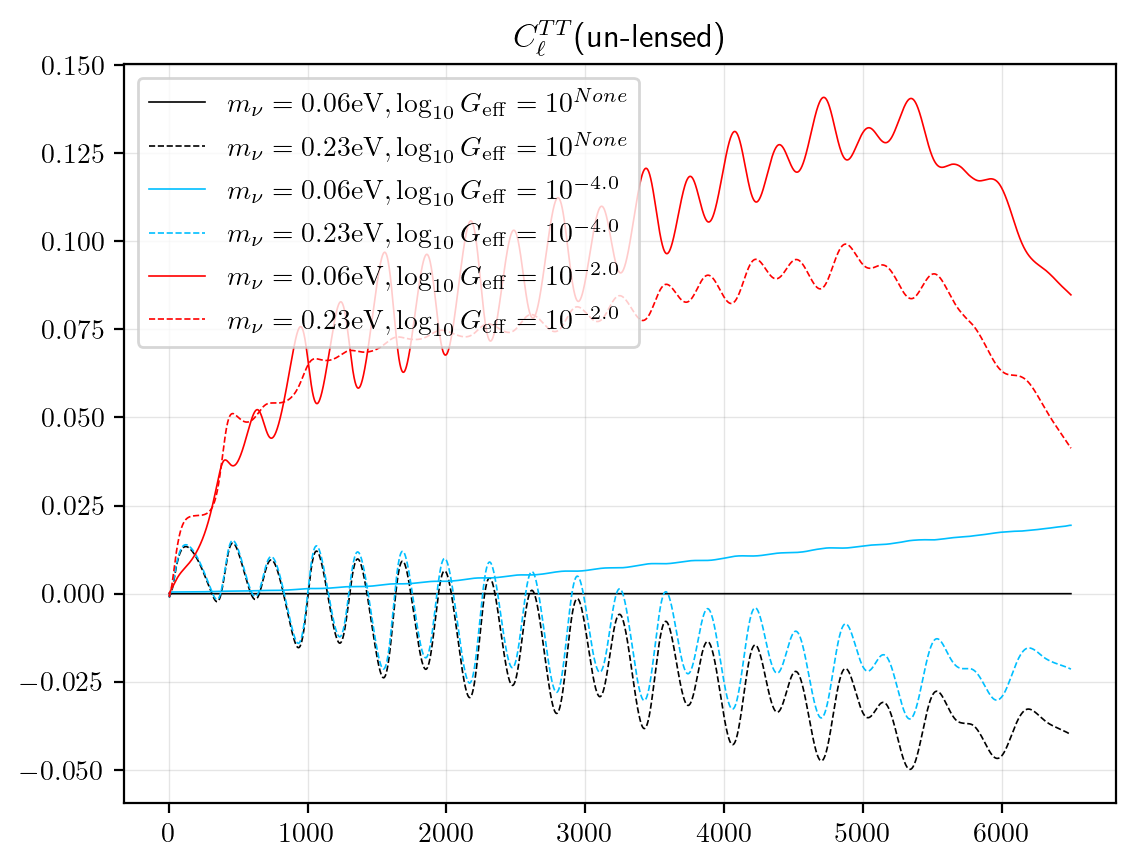

In [9]:
for lin,lgeff in enumerate(lgefflist):
    for mind,m in enumerate(mlist):
        plt.plot(cl_raw[lin,mind]['ell'][2:],cl_raw[lin,mind]['tt'][2:]/cl_raw[0,0]['tt'][2:] - 1, label = fr'$m_\nu = {round(3*m,2)}{{\rm eV}},\log_{{10}} G_{{\rm eff}} = 10^{{{lgeff}}}$', c = cll[lin],ls = lsl[mind], lw = 0.6)
# plt.xlim([2,6000]) 
# plt.ylim([-0.08,0.12])
mgrid(plt)
plt.title('$C_\ell^{TT}$(un-lensed)')
# plt.yticks([-0.06,-0.02,0.02,0.06,0.1])
plt.legend()

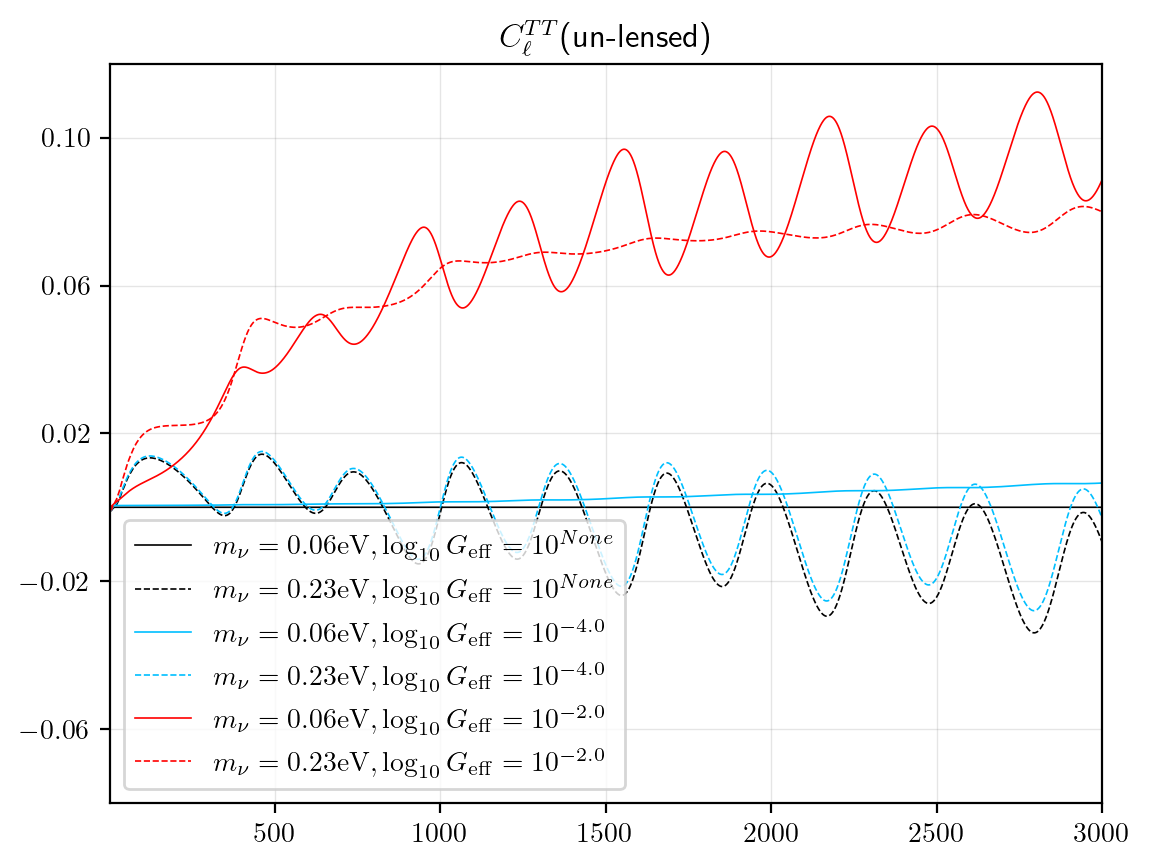

In [10]:
for lin,lgeff in enumerate(lgefflist):
    for mind,m in enumerate(mlist):
        plt.plot(cl_raw[lin,mind]['ell'][2:],cl_raw[lin,mind]['tt'][2:]/cl_raw[0,0]['tt'][2:] - 1, label = fr'$m_\nu = {round(3*m,2)}{{\rm eV}},\log_{{10}} G_{{\rm eff}} = 10^{{{lgeff}}}$', c = cll[lin],ls = lsl[mind], lw = 0.6)
plt.xlim([2,3000]) 
plt.ylim([-0.08,0.12])
mgrid(plt)
plt.title('$C_\ell^{TT}$(un-lensed)')
plt.yticks([-0.06,-0.02,0.02,0.06,0.1])
plt.legend()

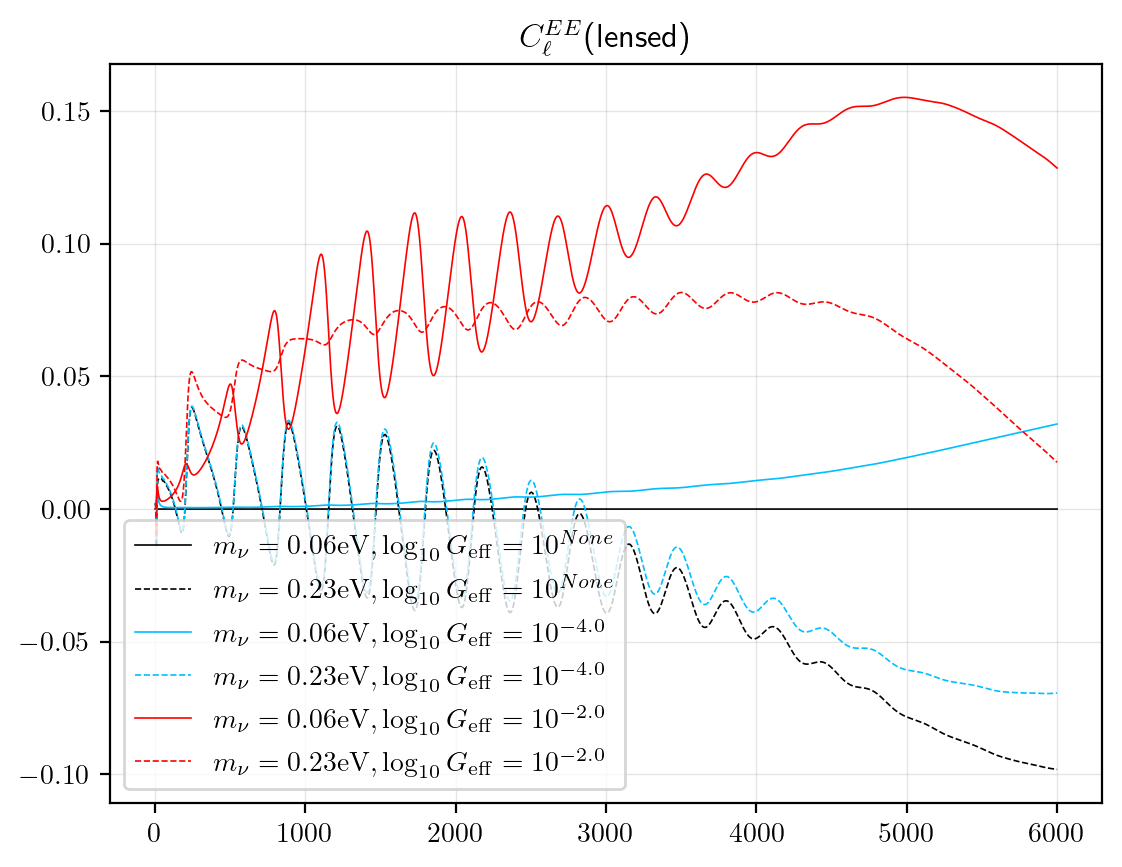

In [11]:
for lin,lgeff in enumerate(lgefflist):
    for mind,m in enumerate(mlist):
        plt.plot(cl[lin,mind]['ell'][2:],cl[lin,mind]['ee'][2:]/cl[0,0]['ee'][2:] - 1, label = fr'$m_\nu = {round(3*m,2)}{{\rm eV}},\log_{{10}} G_{{\rm eff}} = 10^{{{lgeff}}}$', c = cll[lin],ls = lsl[mind], lw = 0.6)
# plt.xlim([2,3000]) 
# plt.ylim([-0.2,0.3])
plt.title('$C_\ell^{EE}$(lensed)')
mgrid(plt)
# plt.yticks([-0.06,-0.02,0.02,0.06,0.1])
plt.legend()
plt.savefig('cl_EE_r.pdf')

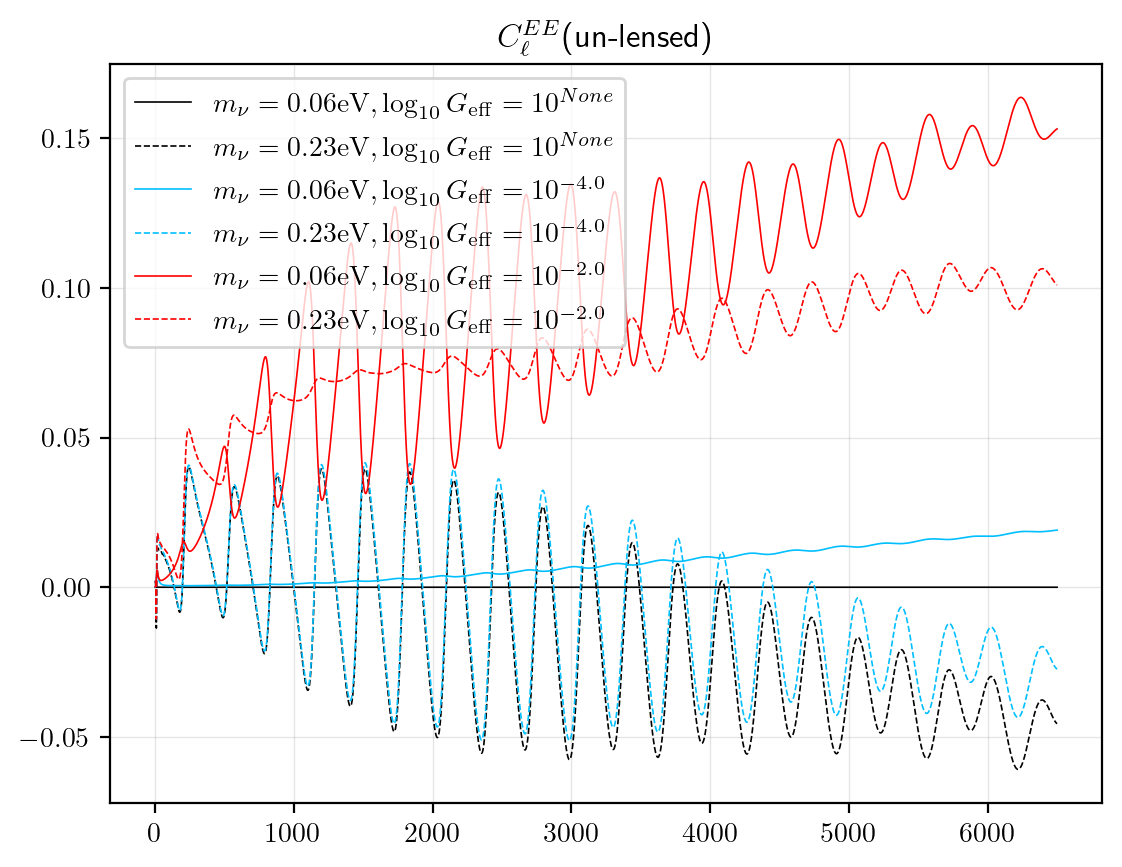

In [12]:
for lin,lgeff in enumerate(lgefflist):
    for mind,m in enumerate(mlist):
        plt.plot(cl_raw[lin,mind]['ell'][2:],cl_raw[lin,mind]['ee'][2:]/cl_raw[0,0]['ee'][2:] - 1, label = fr'$m_\nu = {round(3*m,2)}{{\rm eV}},\log_{{10}} G_{{\rm eff}} = 10^{{{lgeff}}}$', c = cll[lin],ls = lsl[mind], lw = 0.6)
# plt.xlim([2,3000]) 
# plt.ylim([-0.2,0.3])
plt.title('$C_\ell^{EE}$(un-lensed)')
mgrid(plt)
# plt.yticks([-0.06,-0.02,0.02,0.06,0.1])
plt.legend()

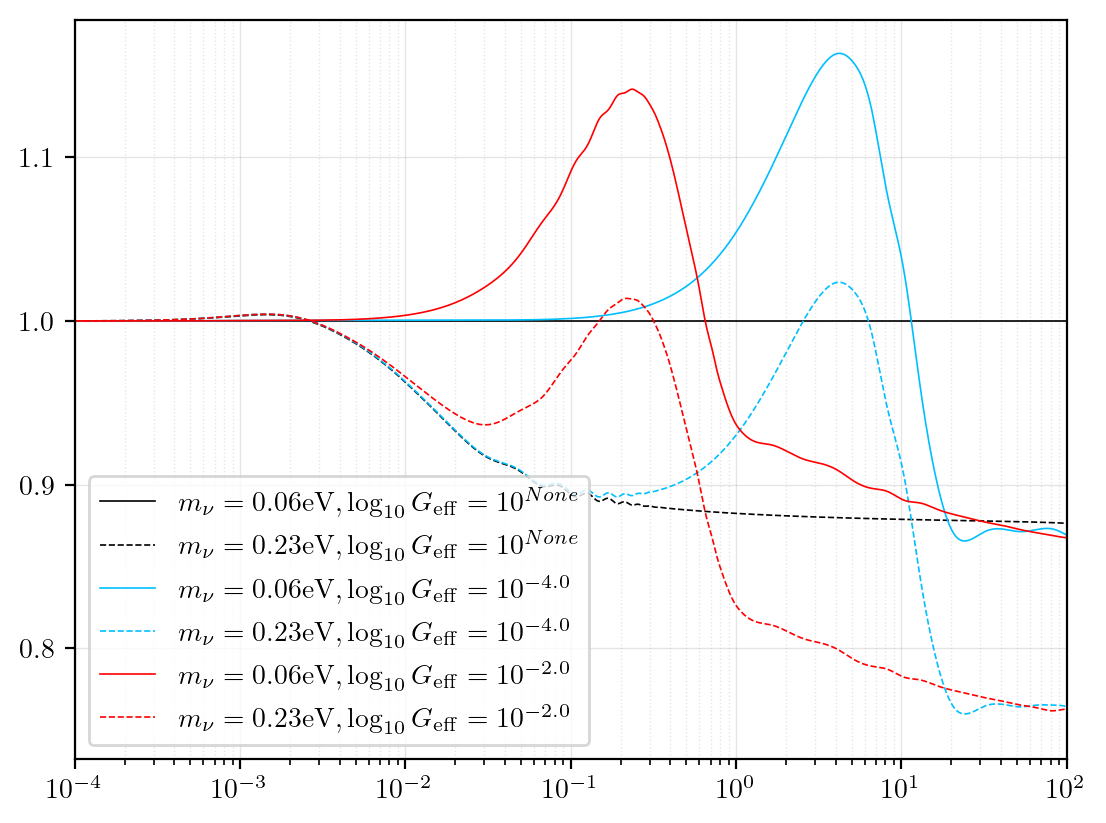

In [13]:
for lin,lgeff in enumerate(lgefflist):
    for mind,m in enumerate(mlist):
        plt.plot(klist,pk[lin,mind]/pk[0,0], label = fr'$m_\nu = {round(3*m,2)}{{\rm eV}},\log_{{10}} G_{{\rm eff}} = 10^{{{lgeff}}}$', c = cll[lin],ls = lsl[mind] ,lw = 0.6)
plt.xscale('log')
plt.xlim([1e-4,1e2])
plt.legend()
mgrid(plt)
plt.savefig('Pk.pdf')
# plt.ylim([-0.08,0.14])

In [14]:
# cl_pk(m_ncdm = 0.02)[1]/pk[0,0]

In [15]:
# cl_pk(m_ncdm = 0.1)[1]/pk[0,0]

In [16]:
#1200